In [187]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
import matplotlib.image as mpimg
from matplotlib.widgets import PolygonSelector
from PIL import Image

plt.style.use('default')

Task1

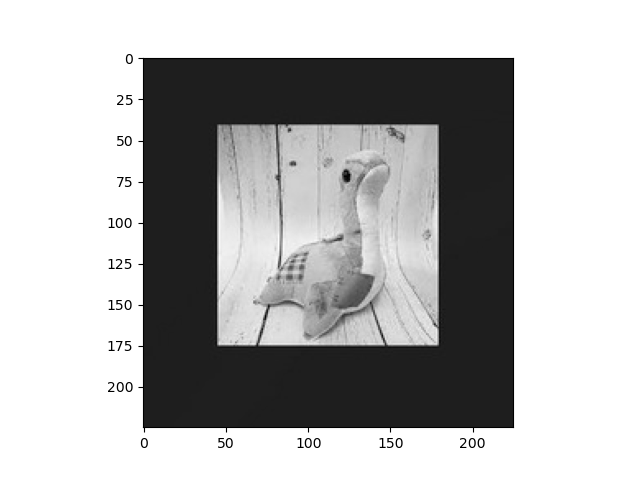

Polygon vertices:
[(48.56638009207586, 130.9935046356994), (133.18488658558238, 50.636361778556534), (175.1897567154525, 103.59902411621886), (115.53066580636158, 174.82467346686823), (46.74008139077716, 157.77921892141367)]


In [188]:
source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
# source_img_path = "InputImgs\\1.png"
# target_img_path = "InputImgs\\2.png"
source_img_grey = cv2.imread(source_img_path, cv2.IMREAD_GRAYSCALE)
target_img_grey = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
target_img_ = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)


img_array = source_img_grey.copy()

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

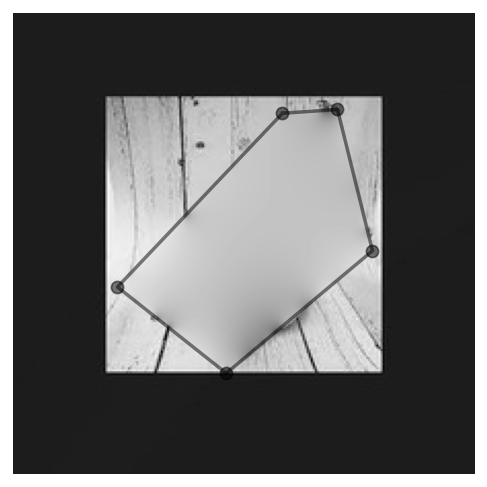

In [189]:
assert 0 != polygon.count, "Please select a polygon in the image above."

%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import polygon2mask
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
from skimage.color import rgb2gray

gray_image = source_img_grey.copy()  # 转换为灰度图像

# 获取图像尺寸
image_height, image_width = gray_image.shape[:2]
# 创建多边形掩码
mask = polygon2mask((image_height, image_width), polygon)

# 获取多边形内部的像素索引
interior_idx = np.argwhere(mask)

# 初始化稀疏矩阵A和向量b
n_interior_pixels = len(interior_idx)
A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
b = np.zeros(n_interior_pixels)

# 构建线性系统
for i, (row, col) in enumerate(interior_idx):
    A[i, i] = 4  # 主对角线元素
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 四个方向的邻居
        neighbor = (row + drow, col + dcol)
        if mask[neighbor]:  # 如果邻居在内部
            j = np.argwhere(np.all(interior_idx == neighbor, axis=1))[0, 0]
            A[i, j] = -1
        else:
            # 如果邻居在边界上或者在掩码外面，我们需要从源图像中获取对应的强度值
            b[i] += gray_image[neighbor]

# 将A矩阵转换为CSR格式
A_csr = A.tocsr()

# 求解线性系统
solution = spsolve(A_csr, b)

# 将解填充回图像的相应区域
for (solution_value, (row, col)) in zip(solution, interior_idx):
    # print(row, col)
    gray_image[row, col] = solution_value

# 显示填充后的图像
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

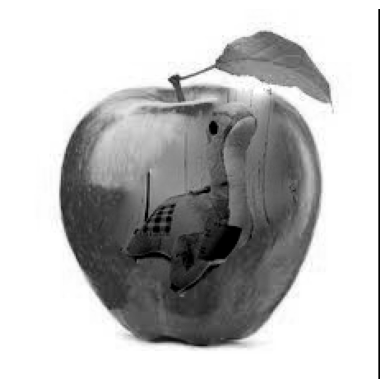

array([[255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       ...,
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0]], dtype=uint8)

In [208]:
from scipy import signal

source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
source_img = Image.open(source_img_path).convert('L')
target_img = Image.open(target_img_path).convert('L')
source_img_array = np.array(source_img, dtype=np.uint8)
target_img_array = np.array(target_img, dtype=np.uint8)

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, polygon, mode='importing'):
    # 创建拉普拉斯算子
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    # 计算源图像的拉普拉斯算子
    grad_source = signal.convolve2d(source_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    grad_target = signal.convolve2d(target_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    # 获取掩码内的索引
    idx = np.argwhere(mask)
    
    # 创建系数矩阵A和向量b
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)
    
    for i, (row, col) in enumerate(idx):
        A[i, i] = 4
        if mode == 'importing':
            b[i] -= grad_source[row, col]
        elif mode == 'mixing':
            # 使用源图像和目标图像的最大梯度
            if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                    b[i] -= grad_source[row, col]
            else:
                b[i] -= grad_target[row, col]
        for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (row + drow, col + dcol)
            if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                if mask[neighbor]:
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    if j.size > 0:
                        A[i, j[0][0]] = -1
                else:
                    b[i] += target_img[neighbor]
    
    
    # 解线性方程组
    solution = spsolve(A.tocsr(), b)
    #solution = np.round(solution).astype(np.uint8)

    # 创建一个新的目标图像以填充结果
    cloned_img = target_img.copy()
    for (row, col), value in zip(idx, solution):
        cloned_img[row, col] = np.clip(value, 0, 255)

    plt.imshow(cloned_img, cmap='gray')
    plt.axis('off')
    plt.show()
    return cloned_img

# 使用导入梯度
seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='importing')
#seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='mixing')

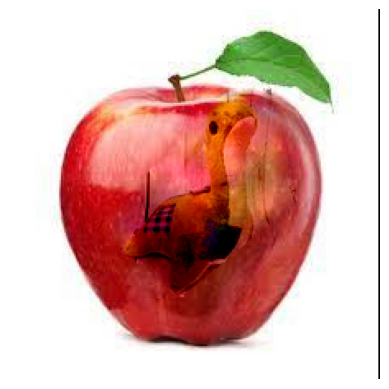

In [211]:
from PIL import Image
from scipy import signal, sparse
import numpy as np
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, mode='importing'):
    cloned_img = np.empty_like(target_img)
    for channel in range(3):
        source_channel = source_img[:,:,channel]
        target_channel = target_img[:,:,channel]

        # Compute Laplacian
        laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)
        grad_target = signal.convolve2d(target_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

        # Get mask indices
        idx = np.argwhere(mask)

        # Create coefficient matrix A and vector b
        n_pixels = len(idx)
        A = sparse.lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            if mode == 'importing':
                b[i] -= grad_source[row, col]
            elif mode == 'mixing':
                # 使用源图像和目标图像的最大梯度
                if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                        b[i] -= grad_source[row, col]
                else:
                    b[i] -= grad_target[row, col]
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            A[i, j[0][0]] = -1
                    else:
                        b[i] += target_channel[neighbor]

        # Solve linear system
        solution = spsolve(A.tocsr(), b)

        # Fill in the cloned image
        channel_cloned = target_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_cloned[row, col] = np.clip(value, 0, 255)
        cloned_img[:,:,channel] = channel_cloned

    return cloned_img


source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)


# 使用导入梯度
#result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='importing')
result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing')

# 展示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

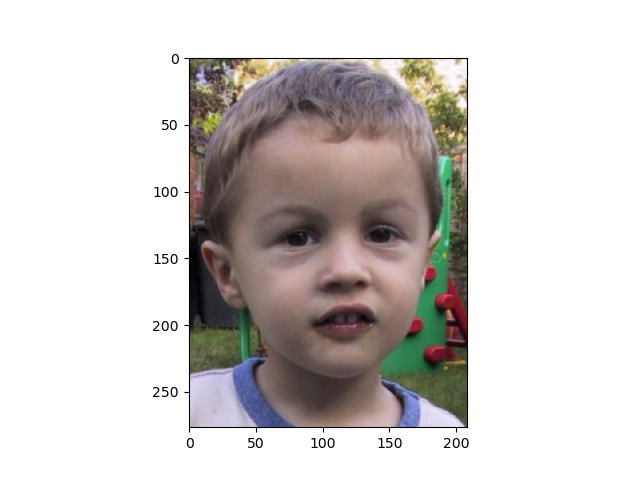

Polygon vertices:
[(92.13326326180331, 64.42856914140447), (89.88488663842668, 161.10876394659928), (122.86107711461716, 176.84740031023566), (211.29722430076433, 147.6185042063395), (218.0423541708942, 70.42424013707546), (134.85241910595914, 38.19750853534387)]


In [268]:
%matplotlib widget
# 应用纹理平坦化
img_path = "InputImgs//qwe.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_array = image.copy()

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

In [273]:
%matplotlib inline
import numpy as np
import cv2
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy import signal


def compute_divergence(grad_x, grad_y):
    """Compute the divergence of the gradient field"""
    div_grad = np.zeros_like(grad_x)
    
    # Compute the difference in x-direction
    div_grad[:-1, :] += grad_x[1:, :] - grad_x[:-1, :]
    # Compute the difference in y-direction
    div_grad[:, :-1] += grad_y[:, 1:] - grad_y[:, :-1]
    
    return div_grad

def gen_edge_map(img, mask):
    """生成边缘映射，只保留掩膜内的边缘"""
    edges = cv2.Canny(img, 100, 200)
    return edges * mask

def texture_flattening(source_img, mask):
    """纹理平坦化函数，通过修改图像梯度后使用泊松方程来平滑选定区域的纹理"""
    # 确保掩膜是布尔类型
    mask = mask.astype(bool)

    # 创建一个空数组，用于存储平坦化后的图像
    flattened_img = np.zeros_like(source_img)

    for channel in range(3):  # 对RGB的每个通道进行处理
        source_channel = source_img[:, :, channel].astype('float64')

        # 计算梯度
        grad_x, grad_y = compute_gradients(source_channel)

        # 生成边缘映射，只保留掩膜内的边缘
        edge_map = gen_edge_map(source_img[:, :, channel], mask)

        # 将边缘以外的梯度设置为0
        grad_x *= edge_map
        grad_y *= edge_map

        # 拉普拉斯算子是梯度的散度，这里我们用梯度的x和y分量来近似
        div_grad = compute_divergence(grad_x, grad_y)

        # 建立方程组的A矩阵和b向量
        idx = np.argwhere(mask)
        n_pixels = len(idx)
        A = lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if mask[neighbor]:
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    if j.size > 0:
                        A[i, j[0][0]] = -1
                else:
                    b[i] += source_channel[neighbor]

        # 添加梯度的散度到b向量中
        for i, (row, col) in enumerate(idx):
            b[i] -= div_grad[row, col]

        # 解决线性系统
        solution = spsolve(A.tocsr(), b)

        # 填充平坦化后的图像
        for (row, col), value in zip(idx, solution):
            flattened_img[row, col, channel] = value

    # 确保图像在正确的范围内
    flattened_img = np.clip(flattened_img, 0, 255).astype('uint8')

    return flattened_img

# 应用纹理平坦化
img_path = "InputImgs//qwe.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width = image.shape[:2]
mask = polygon2mask((image_height, image_width), polygon)
flat_img = texture_flattening(image, mask)

# 展示原始图像和平坦化后的图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(flat_img)
axes[1].set_title('Flattened Image')
axes[1].axis('off')

plt.show()


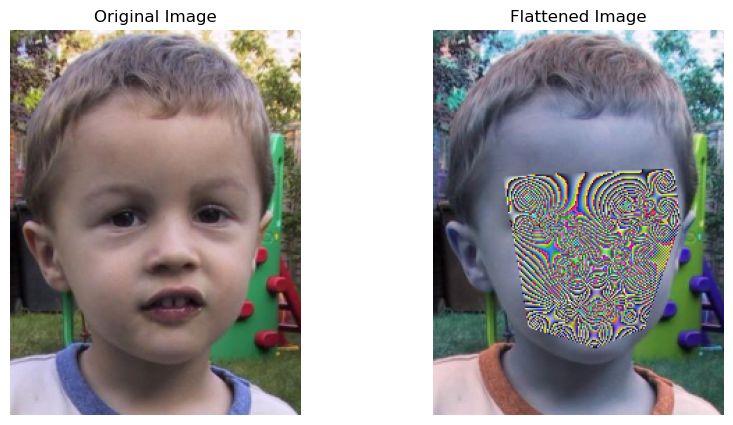

In [243]:
# 读取图像
border_img = cv2.imread("InputImgs//qwe.png")
gray_img = cv2.cvtColor(border_img, cv2.COLOR_BGR2GRAY)

# TODO: 这里需要一个方法来手动选择区域并创建掩膜
# 例如，可以使用图像编辑软件手动创建掩膜并保存为一个文件，然后读取这个文件
mask = polygon2mask((image_height, image_width), polygon)

# 使用 Canny 算法检测边缘
edge_img = cv2.Canny(gray_img, 100, 200)

# 高通滤波器
H = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
grad_img = cv2.filter2D(border_img, -1, H)

# 获取图像尺寸
m, n, _ = border_img.shape

# 初始化变量
num_pixels = np.sum(mask)
I, J = np.nonzero(mask)
index_matr = np.zeros_like(mask, dtype=int)

for count, (i, j) in enumerate(zip(I, J)):
    index_matr[i, j] = count

# 创建稀疏矩阵和 B 数组
Coeff_matr = lil_matrix((num_pixels, num_pixels))
B = np.zeros((num_pixels, 3))

for i in range(1, m - 1):
    for j in range(1, n - 1):
        if mask[i, j]:
            idx = index_matr[i, j]
            Coeff_matr[idx, idx] = 4
            for delta in [-1, 1]:
                # 检查并处理水平邻居
                if mask[i, j + delta]:
                    Coeff_matr[idx, index_matr[i, j + delta]] = -1
                else:
                    B[idx] += border_img[i, j + delta]

                # 检查并处理垂直邻居
                if mask[i + delta, j]:
                    Coeff_matr[idx, index_matr[i + delta, j]] = -1
                else:
                    B[idx] += border_img[i + delta, j]

            if edge_img[i, j]:
                B[idx] += grad_img[i, j]
            else:
                for delta in [-1, 1]:
                    if edge_img[i + delta, j] or edge_img[i, j + delta]:
                        B[idx] += border_img[i, j] - border_img[i + delta, j]

# 解线性方程组
solns = spsolve(Coeff_matr.tocsr(), B)

# 应用解到图像上
final_img = np.copy(border_img)
for k in range(num_pixels):
    i, j = I[k], J[k]
    final_img[i, j] = solns[k]

# 展示原始图像和平坦化后的图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(final_img)
axes[1].set_title('Flattened Image')
axes[1].axis('off')

plt.show()